# Pymaceuticals MatPlotLib-Challenge
This notebook explores the numby, scipy and matloplib.pyplot libraries and uses their functionality to analyse mouse drug treatment data. The two sources of data, randomly generated with [Mockaroo, LLC](https://mockaroo.com/), included study data about 249 mice with cancer, treated with different drug regimen. The analysis performed in this notebook uses summary statistics and grapghs/visuals to help interprit which drug regimen is best. 

## Preparing the Data
First the data is parced as dataframes from csv using pandas. The top few rows of each df are shown to get an idea of what information they hold and the print out of info shows what data types are being used and how many rows have valid entires for each column.

In [1]:
# Dependencies
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import numpy as np
import random as rd

# Create paths to reasources
mouse_data_path = os.path.join('Data', 'Mouse_metadata.csv')
study_results_path = os.path.join('Data', 'Study_results.csv')

# # Read mouse_data as a df named mouse_df and take a look
mouse_df = pd.read_csv(mouse_data_path)
mouse_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16


In [2]:
# Read study_results as a df named study_df and take a look
study_df = pd. read_csv(study_results_path)
study_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [3]:
# Sort values in study df by ID then timepoint to show how timepoints are used for same mouse
study_df.sort_values(['Mouse ID', 'Timepoint']).head(15)

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
113,a203,0,45.000000,0
389,a203,5,48.508468,0
598,a203,10,51.852437,1
758,a203,15,52.777870,1
1018,a203,20,55.173336,1
1295,a203,25,56.793208,1
1315,a203,30,59.523197,1
1577,a203,35,61.931650,2
1675,a203,40,63.593490,2
1804,a203,45,67.973419,2


The first df appears to have one row of data for each mouse in the study, containing info about the specific mouse: sex, age, wight as well as the drug regimen used on that mouse in the study. The second df includes multiple rows of data for each mouse. The set of rows for the same mouse show data across time: Timepoint marks 5 day intervals where study data is clollected. The study data includes Tumor Volume nad Metastatic Sites for each mouse and Timepoint. It is importantto note that not all mice have the same number of timpoints (some mice die before study is completed). 

In [4]:
# Print infor about mouse df
mouse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Mouse ID      249 non-null    object
 1   Drug Regimen  249 non-null    object
 2   Sex           249 non-null    object
 3   Age_months    249 non-null    int64 
 4   Weight (g)    249 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 9.9+ KB


In [5]:
# Print info about study df
study_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893 entries, 0 to 1892
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mouse ID            1893 non-null   object 
 1   Timepoint           1893 non-null   int64  
 2   Tumor Volume (mm3)  1893 non-null   float64
 3   Metastatic Sites    1893 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 59.3+ KB


Since all the columns show the same number of non-null entries, both dfs (most likely) contain no missing data. Looking at lenght of the Mouse df and length of the unique Mouse IDs in the study data shows that they both reffernce the same number of mice (probably the same mice!).

In [6]:
# Print length of mouse df
len(mouse_df['Mouse ID'])

249

In [7]:
# Print length of the unique Mouse IDs in study df 
len(study_df['Mouse ID'].unique())

249

Since the mice df has data for each mouse included in the study, it can be appended to the study data. This is assuming that both dfs reference the same mice. Pandas.merge method makes this possible.

In [8]:
# Left merge (mouse data appended to study data)
study_df = pd.merge(study_df, mouse_df, how='left')
study_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29
3,a457,0,45.0,0,Ketapril,Female,11,30
4,c819,0,45.0,0,Ketapril,Male,21,25


Looking at the length of the newly merged df shows there is a one-to-one relation between IDs in both df since no ID was lost or added. Looking at number of rows for each ID at timepoint 0 shows that one mouse, g989, is repeated.

In [9]:
# Check length of merge df is consistant with original data/show if any mouse IDs are repeated on timepoint 0.
study_df.loc[study_df['Timepoint'] == 0, ['Mouse ID']].value_counts()

Mouse ID
g989        2
a203        1
s121        1
q597        1
q610        1
           ..
j246        1
j296        1
j365        1
j755        1
z969        1
Length: 249, dtype: int64

In [10]:
# Show all rows for g989 mouse
study_df.loc[study_df['Mouse ID'] == 'g989', :]

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


Looking at all rows for the g989 ID shows duplicate data was recorded for this Mouse ID across multiple Timepoints. One possibility is that in the study, the data was entered for the wrong mouse under this ID. Another possibility is that multiple data was accidently taken for this mouse. Since the origin of the data is not know, it is not valid and is removed from the rest of the analyis; all rows with data for Mouse Id g989 are removed from the df.

In [11]:
# Drop all the rows linked to mouse ID g989
study_df.drop(index=[107,137,329,360,620,681,815,869,950,1111,1195,1380,1592], inplace=True)
mouse_df.drop(index=107, inplace=True)

In [12]:
# Show new length of unique mouse IDs after dropping g989
len(study_df['Mouse ID'].unique())

248

The new number of unique Mouse Ids is 248, since g989 was removed. The study_df dataframe is used for the remainder of the analysis. Each row includes all mouse specific data and tumor volume and metastatic sites for specific timestamp.

## Summary Statistics
With cleaned up data, a summary statistics table is prooduced showing the central tendancy of the Volume of Tumor for each drug regiment in the study. It is important to note that all values on the tumor volume are incuded for each regiment meaning that as single mouse will be included several times across multiple timepoints. 

In [13]:
# Intialize summary df
summary_df = pd.DataFrame()

# Group rows by drug regimen mean, median, variance, std and sem to fill in summary table
summary_df['Mean'] = study_df.groupby('Drug Regimen').mean()['Tumor Volume (mm3)']
summary_df['Median'] = study_df.groupby('Drug Regimen').median()['Tumor Volume (mm3)']
summary_df['Variance'] = study_df.groupby('Drug Regimen').var()['Tumor Volume (mm3)']
summary_df['std'] = study_df.groupby('Drug Regimen').std()['Tumor Volume (mm3)']
summary_df['SEM'] = study_df.groupby('Drug Regimen').sem()['Tumor Volume (mm3)']

summary_df

,Mean,Median,Variance,std,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


One thing to note is that tumor volume does not appear to be a scewed distribution since the medians and means are relatively close to each other. Additionally, the standard errors (SEM) are small commpared to the means, indicating that the data is tightly distributed around the mean. 

In [14]:
# Compute the same table from above using a groupby/aggregate method instead
summary_df = study_df.groupby('Drug Regimen').agg(Mean=('Tumor Volume (mm3)','mean'),
                                                 Meadian=('Tumor Volume (mm3)','median'),
                                                 Variance=('Tumor Volume (mm3)','var'),
                                                 std=('Tumor Volume (mm3)','std'),
                                                 SEM=('Tumor Volume (mm3)','sem'))
summary_df

,Mean,Meadian,Variance,std,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


 ## Number of Timepoints (Bar Chart)
 The following bar gragh shows how many timepoints were collected for each drug regimen and shows how much data is available for each regimen. This is a reflection on the study's setup - how many mice were selected for each regimen - as well as a reflection of the results - more timepoints per mouse indicates mice living longer.

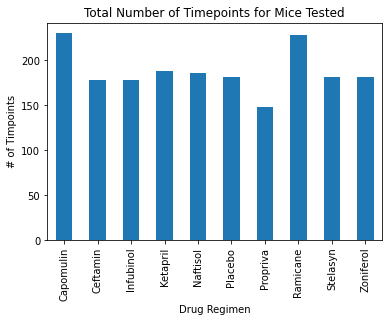

In [15]:
# Create df that holds the total number of timepoints by each drug
timepoint_counts_by_drug = study_df.groupby('Drug Regimen').count()['Timepoint']

# Plot the above data uding the pandas.DataFrame.plot method
timepoint_counts_by_drug.plot(kind='bar', ylabel='# of Timpoints', title='Total Number of Timepoints for Mice Tested')
plt.show()

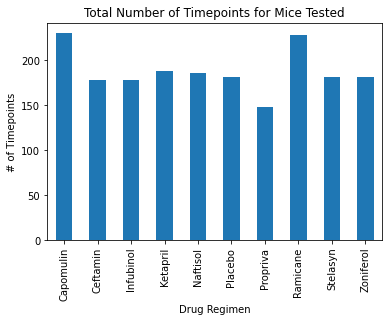

In [16]:
# Create 10 locations (one for each unique drug in study)
x_axis = np.arange(len(timepoint_counts_by_drug))

# Create a list (df) of all the drug names, alphabetized
labels = study_df.sort_values('Drug Regimen')['Drug Regimen'].unique()

# Plot df using the matplotlib.pyplot.plot method
plt.bar(x_axis, timepoint_counts_by_drug, width=.5)
plt.xticks(x_axis, labels, rotation='vertical')
plt.xlim(-0.5, len(x_axis)-0.5)
plt.xlabel('Drug Regimen')
plt.ylabel('# of Timepoints')
plt.title('Total Number of Timepoints for Mice Tested')
plt.show()

## Number of Mice by Sex (Pie Chart)
The following pie charts show the total number of mice for each sex included in the study. The study was faily evenly distributed between sex and therefore, there is no reason to believe the results of the study are restricted to a particular sex.

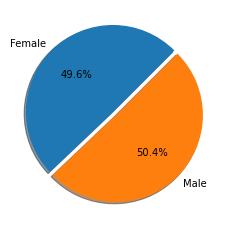

In [17]:
# Plot number of each sex in pie chart using the pandas.DataFrame.plot method
mouse_df.groupby('Sex').count()['Mouse ID'].plot(kind='pie', ylabel='', autopct='%.1f%%', shadow=True, startangle=45, explode=[.05,0])
plt.show()

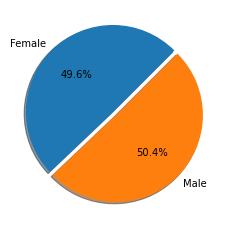

In [18]:
# Store the conut of each sex in df 
sex_counts = mouse_df.groupby('Sex', as_index=False).count()['Mouse ID']

# Store all the different sexes in list
labels = mouse_df.groupby('Sex', as_index=False).count()['Sex']

# Plot pie chart using matplotlib.pyplot.plot method
plt.pie(sex_counts, labels=labels, autopct='%.1f%%', shadow=True, startangle=45, explode=[.05,0])
plt.show()

## Final Tumor Volume Summary Table by Drug Regimen

In [19]:
# Create df that stores maximum timepoint for each mouse ID
greatest_timepoint_by_ID = study_df.groupby('Mouse ID').max()['Timepoint']

# Merge new df with original on ID and timepoint for each pair of ID and timepoint from the new df (the one that only has the maximun timepoints)
greatest_timepoint_by_ID = pd.merge(greatest_timepoint_by_ID, study_df, on=['Mouse ID','Timepoint'], how='left')

# Create a list of Drug Regimens of interest
drugs = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Intiate some lists to store data from the following for loop:
final_volume_list = []
outlier_list = []
volume_by_drug_summary = pd.DataFrame()

# Loop through the different drug regimens
for index, drug in enumerate(drugs):
    
    # Get all tumor volumes at max timepoint for current regimen
    final_volume = greatest_timepoint_by_ID.loc[greatest_timepoint_by_ID['Drug Regimen'] == drug, :]
    
    # Store the tumor volume data as a list as the first entry in the volume list
    final_volume_list.append(final_volume['Tumor Volume (mm3)'])
    
    # Read quartiles and fill in summary table
    quars = final_volume_list[index].quantile([.25,.5,.75])
    volume_by_drug_summary.loc[drug, 'Q1'] = quars[.25]
    volume_by_drug_summary.loc[drug, 'Median'] = quars[.5]
    volume_by_drug_summary.loc[drug, 'Q3'] = quars[.75]
    volume_by_drug_summary.loc[drug, 'IQR'] = quars[.75] - quars[.25]
    volume_by_drug_summary.loc[drug, 'Lower Bound'] = quars[.25] - 1.5 * (quars[.75] - quars[.25])
    volume_by_drug_summary.loc[drug, 'Upper Bound'] = quars[.75] + 1.5 * (quars[.75] - quars[.25])
    volume_by_drug_summary.loc[drug, 'Number of Outliers'] = final_volume.loc[(final_volume['Tumor Volume (mm3)'] > volume_by_drug_summary.loc[drug, 'Upper Bound']) | (final_volume['Tumor Volume (mm3)'] < volume_by_drug_summary.loc[drug, 'Lower Bound']), 'Tumor Volume (mm3)'].count()    
    
    # Fill list of outliers
    outlier_list.append(final_volume.loc[(final_volume['Tumor Volume (mm3)'] > volume_by_drug_summary.loc[drug, 'Upper Bound']) | (final_volume['Tumor Volume (mm3)'] < volume_by_drug_summary.loc[drug, 'Lower Bound']), :])

Summary table of final tumor volume for each drug regimen:

In [20]:
# Show the summary table created with the previous code
volume_by_drug_summary

,Q1,Median,Q3,IQR,Lower Bound,Upper Bound,Number of Outliers
Capomulin,32.377357,38.125164,40.159220,7.781863,20.704562,51.832015,0.0
Ramicane,31.560470,36.561652,40.659006,9.098537,17.912664,54.306811,0.0
Infubinol,54.048608,60.165180,65.525743,11.477135,36.832905,82.741446,1.0
Ceftamin,48.722078,59.851956,64.299830,15.577752,25.355450,87.666458,0.0


The only potential outlier is for Infubinol: mouse c326.

In [21]:
# Show the 3rd element of the outlier list which is the oulier(s) for Infubinol
outlier_list[2]

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
31,c326,5,36.321346,0,Infubinol,Female,18,25


## Final Tumor Volume Box Plot

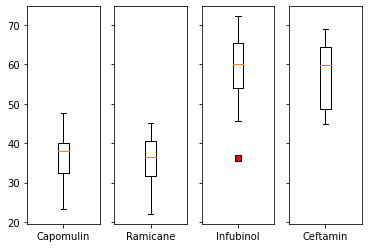

In [22]:
#Create subplots and color outliesr
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, sharey=True)
ax0.boxplot(final_volume_list[0], labels=['Capomulin'], flierprops={'markerfacecolor':'r','marker':'s'})
ax1.boxplot(final_volume_list[1], labels=['Ramicane'], flierprops={'markerfacecolor':'r','marker':'s'})
ax2.boxplot(final_volume_list[2], labels=['Infubinol'], flierprops={'markerfacecolor':'r','marker':'s'})
ax3.boxplot(final_volume_list[3], labels=['Ceftamin'], flierprops={'markerfacecolor':'r','marker':'s'})
plt.show()

The above set of boxplots show the distribution of final tumor volumes by drug regimen type. The main take away is that both Capomulin and Ramicane are much more effective that Infubinol and Ceftamin at reducing tumor volume. This is a strong indicator that both Capomulin and Ramicane are successful at reducing Tumor volume. While Infubinol does include one outlier tumor volume value, Mouse ID c326, that is it well into the range of values for Capomulin and Ramicane. The final timpoint for this mouse is 5 days meaning the mouse most likely died less than 10 days in the study. From the data it is not clear if this was systematic error or if this mouse really did decrease in tumor volume in 5 days and then pass. Either way, Infubinol's distribution is much higher than the Capomulin and Ramicane.

## Tumor Volume Over Time Line Plot

In [23]:
# Get rows from original df with Capomulon drug regimen
capomulin_df = study_df.loc[study_df['Drug Regimen'] == 'Capomulin', :]

# Pick a random Mouse ID from the capomulin df
rand_ID = rd.choice(list(capomulin_df['Mouse ID']))

In [24]:
# Get all rows for b128
sample_from_capomulin = study_df.loc[study_df['Mouse ID'] == rand_ID, :]
sample_from_capomulin

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
237,w914,0,45.000000,0,Capomulin,Male,24,21
309,w914,5,45.893720,0,Capomulin,Male,24,21
645,w914,10,43.231963,0,Capomulin,Male,24,21
873,w914,15,43.688449,0,Capomulin,Male,24,21
983,w914,20,41.108092,0,Capomulin,Male,24,21
1181,w914,25,40.291917,0,Capomulin,Male,24,21
1356,w914,30,40.993110,0,Capomulin,Male,24,21
1494,w914,35,41.664916,1,Capomulin,Male,24,21
1732,w914,40,35.611309,2,Capomulin,Male,24,21
1838,w914,45,36.041047,2,Capomulin,Male,24,21


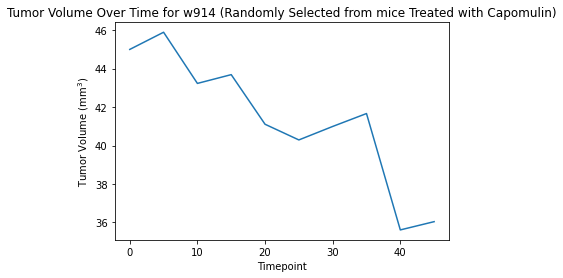

In [25]:

# Plot the tumor volumes oof b128 vs the timepoints for b128
plt.plot(sample_from_capomulin['Timepoint'], sample_from_capomulin['Tumor Volume (mm3)'])
plt.xlabel('Timepoint')
plt.ylabel('Tumor Volume (mm$^{3}$)')
plt.title(f'Tumor Volume Over Time for {rand_ID} (Randomly Selected from mice Treated with Capomulin)')
plt.show()

The graph shows tumor value over time for a randomly selected mouse treated with Capomulin. It appears to have a Tumor volume decrease over time. If it is representative of Capomulin's general effect on mice, it is a good sign that Capomulin is successful. 

## Average Tumor Volume vs. Weight Scatter Plot

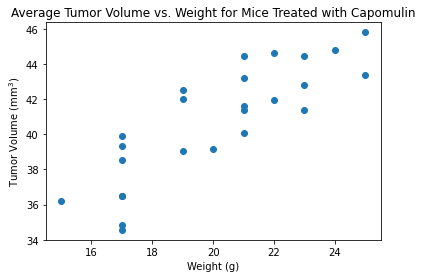

In [26]:
# Create a df stores the average (over all timepoints) tumor volume for each mouse treated with Capomulin 
average_volume_by_ID_for_capomulin = (study_df.loc[study_df['Drug Regimen'] == 'Capomulin', :]).groupby('Mouse ID').mean()

# Plot average tumor volume vs weight for Capomulin 
plt.scatter(average_volume_by_ID_for_capomulin['Weight (g)'], average_volume_by_ID_for_capomulin['Tumor Volume (mm3)'])
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm$^{3}$)')
plt.title('Average Tumor Volume vs. Weight for Mice Treated with Capomulin')
plt.show()

Above shows the Tumor volume for each mouse treated with Capomulin, averaged across all timepoints, vs the weight of that mouse. At first glance, it appears to have a slight positive correlation. Below is the same graph but with a linear regression.

## Correlation Between Average Tumor Volume and Weight for Mice Treated with Capomulin and Scatter Plot with Best-fit Line

Correlation coefficient for Average Tumor Volume vs Weight of mice treated with capomulin is:

In [27]:
# Compute Pearson's r value
round(st.pearsonr(average_volume_by_ID_for_capomulin['Weight (g)'], average_volume_by_ID_for_capomulin['Tumor Volume (mm3)'])[0],2)

0.84

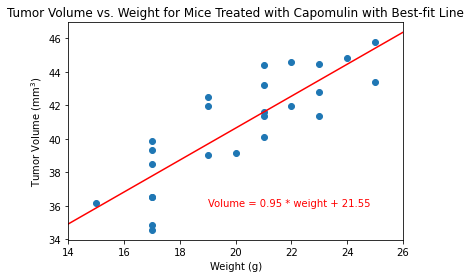

In [28]:
# Compute linear regression and unpack values to tuple
m, b, r, p, e = st.linregress(average_volume_by_ID_for_capomulin['Weight (g)'], average_volume_by_ID_for_capomulin['Tumor Volume (mm3)'])

# Use values from tuple to make a string that summarizes the lin reg
eq = f'Volume = {round(m,2)} * weight + {round(b,2)}'

# Plot the Scatter plot again, this time with lin reg equation
plt.scatter(average_volume_by_ID_for_capomulin['Weight (g)'], average_volume_by_ID_for_capomulin['Tumor Volume (mm3)'])
plt.xlabel('Weight (g)')
plt.xlim(14, 26)
plt.ylabel('Tumor Volume (mm$^{3}$)')
plt.title('Tumor Volume vs. Weight for Mice Treated with Capomulin with Best-fit Line')
plt.plot(range(14,27), (range(14,27) * m + b), 'r')
plt.text(19, 36, eq, color='red')
plt.show()

In [29]:
print(f'The correlation for the linear regression is {round(r,2)}.')

The correlation for the linear regression is 0.84.


The line of best fit shows postitve correlation between weight and average tumor volume meaning that the more the mouse weighs the larger the tumor volume. The correlation value of 0.84 indicates a fairly strong positive correlation.

## Analysis
This notebook has explored the study data for 249 (248 valid, 1 with inconsistant data) mice treated with 10 different drug regimens overa 45 day trial. The study's aim was to prove **Capomulin**, is more effective than the other drug treatements in the study. While the analysis does not confirm that Capomulin is the best treatment, it is significantly better than most of the other regimens and it succeeds at reducing tumor volume over the course of the study. The median for Capomulin (41.56) was found to be comparable only to **Ramicane** (40.67). The gragh of boxplots shows that Ramicane and Capomulin have similair effects on tumor volume. Another interesting trend observed is that average tumor volume increase as weight increases (positive correlation)